In [1]:
import pandas as pd
import seaborn as sns


## Import the data

In [2]:
data=pd.read_csv("/Users/richikghosh/Documents/Financial NLP/data.csv",encoding="utf-8")
len(data)

5842

<Axes: xlabel='Sentiment', ylabel='count'>

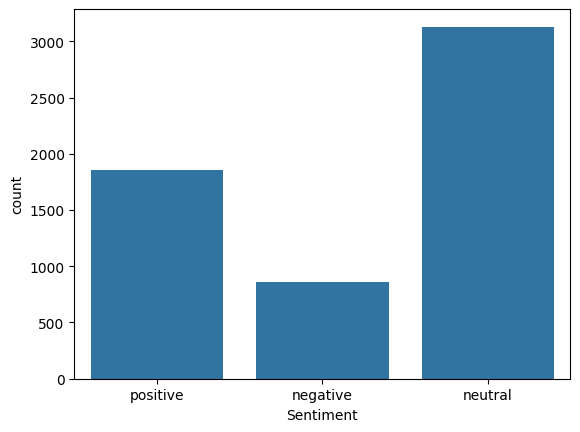

In [7]:
sns.countplot(x="Sentiment",data=data)

## Data Preprocessing


In [9]:
data["Sentiment_num"]=data.Sentiment.map({'negative':0,'neutral':1,'positive':2})

In [304]:
## Custom function to lower and remove punctuations

def remove_punctuations_lower(sentence):
        for i in sentence:
            if i in '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~':
                sentence=sentence.replace(i,"")
        return sentence.lower()

In [41]:
## Here the punctuations are removed and the text is lowered and the it is split based on the spaces
data["Sentence_special"]=data.apply(lambda row: remove_punctuations_lower(row['Sentence']),axis=1)
data["Sentence_special"][0]

'the geosolutions technology will leverage benefon s gps solutions by providing location based search technology  a communities platform  location relevant multimedia content and a new and powerful commercial model '

Preprocessing to remove stop words and punctuations and bring the word to the base form and along with that lower the text

In [3]:
import spacy
from spacy.lang.en import stop_words
nlp = spacy.load('en_core_web_sm')
## This removes the stop words for not looking at the extra words
# def remove_stopwords_punctuations(sentence):
#     fin=[]
#     doc=nlp(str(sentence))
#     for token in doc: 
#         if token.is_punct or not token.is_stop:
#                 fin.append(token.lemma_.lower())
#     return fin 

def remove_stopwords_punctuations(sentence):
    doc=nlp(sentence)
    return ([token.lemma_.lower() for token in doc if not token.is_punct and not token.is_stop and not token.like_num and not token.is_space and not token.is_digit and not token.is_currency])

In [4]:
data['Sentence_special']=data.apply(lambda row:remove_stopwords_punctuations(row['Sentence']),axis=1)


In [38]:
data['Sentence_special'][0]

'geosolutions technology leverage benefon gps solution provide location based search technology communities platform location relevant multimedia content new powerful commercial model'

## Using Afinn for sentiment analysis

In [5]:
from afinn import Afinn

# Create an Afinn object
afinn = Afinn()

def afinn_fit(text):
# Get the sentiment score for the text
    text=str(text)
    sentiment_score = afinn.score(text)
    return sentiment_score


In [7]:
data['Afinn_score']=data.apply(lambda row: afinn_fit(row["Sentence_special"]),axis=1)

<Axes: xlabel='Afinn_score', ylabel='Count'>

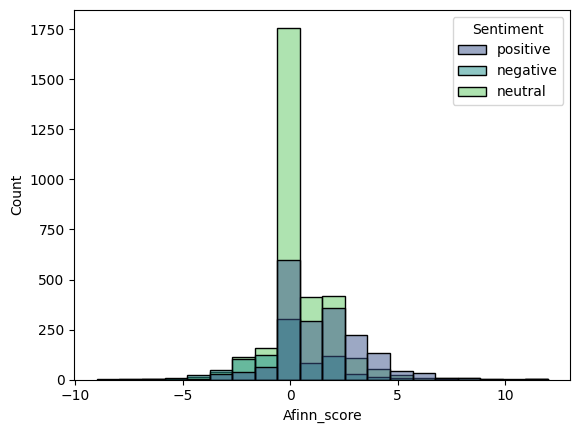

In [8]:
sns.histplot(x='Afinn_score', hue='Sentiment', data=data, bins=20, multiple="layer", palette='viridis', edgecolor='black')

In [9]:
data['Emotion'] = pd.cut(data['Afinn_score'], bins=[-float('inf'), -1, 1, float('inf')],labels=['negative', 'neutral', 'positive'], include_lowest=True)


Sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64

In [10]:

data[data['Emotion']==data['Sentiment']]

,Sentence,Sentiment,Sentence_special,Afinn_score,Emotion
0,The GeoSolutions technology will leverage Bene...,positive,geosolutions technology leverage benefon gps s...,3.0,positive
3,According to the Finnish-Russian Chamber of Co...,neutral,accord finnish russian chamber commerce major ...,0.0,neutral
4,The Swedish buyout firm has sold its remaining...,neutral,swedish buyout firm sell remain percent stake ...,0.0,neutral
6,Shell's $70 Billion BG Deal Meets Shareholder ...,negative,shell bg deal meet shareholder skepticism,-2.0,negative
7,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative,ssh communications security corp stock exchang...,-3.0,negative
...,...,...,...,...,...
5834,Investments in product development stood at 6....,neutral,investment product development stand mln euro mln,0.0,neutral
5836,Daily Mail parent company in talks with potent...,positive,daily mail parent company talk potential partn...,2.0,positive
5838,Nordic Walking was first used as a summer trai...,neutral,nordic walking summer training method cross co...,0.0,neutral
5839,"According shipping company Viking Line , the E...",neutral,accord shipping company viking line eu decisio...,1.0,neutral


# From here I will use TF_IDF and ML algos to find the sentiment

In [49]:
data["Sentence_special"]=data.apply(lambda row:str(row["Sentence_special"]),axis=1)

0       ['geosolutions', 'technology', 'leverage', 'be...
1             ['esi', 'low', 'bk', 'real', 'possibility']
2       ['quarter', 'componenta', 'net', 'sale', 'doub...
3       ['accord', 'finnish', 'russian', 'chamber', 'c...
4       ['swedish', 'buyout', 'firm', 'sell', 'remain'...
                              ...                        
5837    ['rise', 'cost', 'force', 'packaging', 'produc...
5838    ['nordic', 'walking', 'summer', 'training', 'm...
5839    ['accord', 'shipping', 'company', 'viking', 'l...
5840    ['building', 'home', 'improvement', 'trade', '...
5841    ['helsinki', 'afx', 'kci', 'konecranes', 'say'...
Name: Sentence_special, Length: 5842, dtype: object

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test=train_test_split(data.Sentence_special,data.Sentiment_num,test_size=0.1,stratify=data.Sentiment_num)

In [21]:
print(f"The shape of the train set:{X_train.shape}")
print(f"The shape of the test set:{X_test.shape}")

The shape of the train set:(5257,)
The shape of the test set:(585,)


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

clf_pipeline=Pipeline([('vetor_tf_idf',TfidfVectorizer()),
               ('KNN',KNeighborsClassifier(n_neighbors=7))])
clf_pipeline.fit(X_train,y_train)
y_pred=clf_pipeline.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.37      0.15      0.21        86
           0       0.59      0.93      0.72       313
           1       0.81      0.23      0.35       186

    accuracy                           0.59       585
   macro avg       0.59      0.44      0.43       585
weighted avg       0.63      0.59      0.53       585



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1

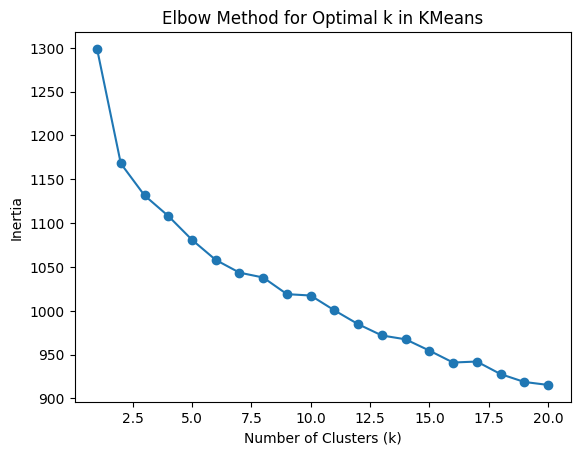

In [23]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

# Assuming 'X_train' contains your text data

# Create a pipeline with TF-IDF vectorization and TruncatedSVD (for dimensionality reduction)
pipeline = make_pipeline(TfidfVectorizer(), TruncatedSVD(n_components=100))

# Fit and transform the text data
X_train_tfidf_svd = pipeline.fit_transform(X_train)

# Initialize a list to store the inertia values
inertia_values = []

# Define a range of k values to try
k_values = range(1, 21)

# Iterate over each k value and compute inertia
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_tfidf_svd)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k in KMeans')
plt.show()


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Assuming 'X_train' and 'y_train' contain your training data
# and 'X_test' contains your test data

# Create a pipeline with TF-IDF vectorization and GradientBoostingClassifier
clf_pipeline = Pipeline([
    ('vector_tf_idf', TfidfVectorizer()),
    ('GB', GradientBoostingClassifier(n_estimators=100, random_state=42))  # You can adjust hyperparameters
])

# Fit the pipeline on the training data
clf_pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf_pipeline.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          -1       0.44      0.16      0.24        86
           0       0.68      0.94      0.79       313
           1       0.85      0.55      0.67       186

    accuracy                           0.70       585
   macro avg       0.65      0.55      0.56       585
weighted avg       0.70      0.70      0.67       585



In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Assuming 'X_train' and 'y_train' contain your training data
# and 'X_test' contains your test data

# Create base models
base_models = [
    ('MultinomialNB', MultinomialNB()),
    ('GB', GradientBoostingClassifier(n_estimators=100, random_state=42))  # You can adjust hyperparameters
]

# Create a stacking classifier with a Gradient Boosting meta-model
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=GradientBoostingClassifier(n_estimators=50, random_state=42))

# Create a pipeline with TF-IDF vectorization and the stacking classifier
clf_pipeline = Pipeline([
    ('vector_tf_idf', TfidfVectorizer()),
    ('stacking_classifier', stacking_clf)
])

# Fit the pipeline on the training data
clf_pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf_pipeline.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


KeyboardInterrupt: 

In [144]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Assuming 'X_train' and 'y_train' contain your training data
# and 'X_test' contains your test data

# Create a pipeline with TF-IDF vectorization and RandomForestClassifier
clf_pipeline = Pipeline([
    ('vector_tf_idf', TfidfVectorizer()),
    ('RandomForest', RandomForestClassifier())  # Hyperparameters will be tuned
])

# Define the hyperparameter grid to search
param_grid = {
    'RandomForest__n_estimators': [50, 100, 150],
    'RandomForest__max_depth': [None, 10, 20],
    'RandomForest__min_samples_split': [2, 5, 10],
}

# Perform a grid search with cross-validation
grid_search = GridSearchCV(clf_pipeline, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          -1       0.13      0.09      0.11        86
           0       0.64      0.81      0.71       313
           1       0.81      0.55      0.66       186

    accuracy                           0.62       585
   macro avg       0.53      0.49      0.49       585
weighted avg       0.62      0.62      0.61       585



In [147]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Assuming 'X_train' and 'y_train' contain your training data
# and 'X_test' contains your test data

# Create base models with manually set hyperparameters
base_models = [
    ('MultinomialNB', MultinomialNB(alpha=1.0)),  # You can adjust alpha as needed
    ('RandomForest', RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2, random_state=42)),  # You can adjust hyperparameters
]

# Create a stacking classifier with a Gradient Boosting meta-model
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=GradientBoostingClassifier(n_estimators=50, random_state=42))

# Create a pipeline with TF-IDF vectorization and the stacking classifier
clf_pipeline = Pipeline([
    ('vector_tf_idf', TfidfVectorizer()),
    ('stacking_classifier', stacking_clf)
])

# Fit the pipeline on the training data
clf_pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf_pipeline.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          -1       0.52      0.16      0.25        86
           0       0.73      0.89      0.81       313
           1       0.76      0.72      0.74       186

    accuracy                           0.73       585
   macro avg       0.67      0.59      0.60       585
weighted avg       0.71      0.73      0.70       585



## Word2Vec using gensim to train in on the corpus present


In [11]:
import gensim


In [31]:
data.Sentence_special

0       geosolutions technology leverage benefon gps s...
1                             esi low bk real possibility
2       quarter componenta net sale double eur131 m eu...
3       accord finnish russian chamber commerce major ...
4       swedish buyout firm sell remain percent stake ...
                              ...                        
5837    rise cost force packaging producer huhtamaki a...
5838    nordic walking summer training method cross co...
5839    accord shipping company viking line eu decisio...
5840    building home improvement trade sale decrease ...
5841    helsinki afx kci konecranes say win order hot ...
Name: Sentence_special, Length: 5842, dtype: object

In [51]:
model=gensim.models.FastText(
    window=3, #This takes the first 10 and last 10 words of the target word
    min_count=1, # Minimum words occurrences should be 1 in a sentence to be considered in our model
    workers=6, #CPU threads to use
    sg=1, # to choose the skip gram model
    min_n=4,
    max_n=10,
    vector_size=300
)

In [52]:
model.build_vocab(data.Sentence_special,progress_per=100)

In [53]:
model.train(data.Sentence_special, total_examples=model.corpus_count, epochs=10)

(564258, 625580)

In [54]:
model.save("final.model")

In [55]:
model.wv.most_similar("rise",topn=10)

[('fall', 0.989277720451355),
 ('turnover', 0.9892289042472839),
 ('margin', 0.9878314733505249),
 ('see', 0.9877700209617615),
 ('riser', 0.9872775077819824),
 ('slightly', 0.9867761731147766),
 ('jump', 0.9866733551025391),
 ('versus', 0.9859814047813416),
 ('drop', 0.9857509136199951),
 ('turn', 0.9854707717895508)]

In [56]:
model.wv.similarity(w1='negative',w2='positive')

0.990028

## Train using SpaCy
SpaCy is going to be trained on English corpus as the default behavior

In [14]:
import spacy
import numpy as np
#spacy.cli.download("en_core_web_lg")
nlp=spacy.load('en_core_web_lg')
def remove_stopwords_punctuations_vec_form(sentence):
    doc=nlp((sentence))
    words = [token.lemma_.lower() for token in doc if not token.is_punct and not token.is_stop and not token.like_num and not token.is_space and not token.is_digit and not token.is_currency and len(token.text)>2]
    string_form=" ".join(words)
    string_form=nlp(string_form)
    vector_form=[token.vector for token in string_form]
    vector_form_mean=np.mean(vector_form,axis=0)
    if vector_form_mean.any():
         return vector_form_mean
    else:
         return np.zeros(300) 


In [15]:
data['Vector_data']=data.apply(lambda row:remove_stopwords_punctuations_vec_form(row["Sentence"]),axis=1)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [19]:
data=data.dropna()
data["Vector_data"][data["Vector_data"].isna()]

Series([], Name: Vector_data, dtype: object)

In [20]:
#data=data.dropna()
for i in data["Vector_data"]:
    if i.shape[0]!=300:
        print("Yes some is diff")

In [99]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(
    data.Vector_data.values,
    data.Sentiment_num,
    test_size=0.2
)
#X_train

In [22]:
### Here we are transforming the vector of words from array of arrays to 2d array
import numpy as np
X_train_stack=np.stack(X_train)
X_test_stack=np.stack(X_test)


In [190]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# Create a pipeline with MinMaxScaler and KNeighborsClassifier
pipe = Pipeline([
    ('Scaler', MinMaxScaler()),
    ('KNN', KNeighborsClassifier(n_neighbors=10))
])

# Fit the pipeline on the training data 
pipe.fit(X_train_stack, y_train)


Pipeline(steps=[('Scaler', MinMaxScaler()),
                ('KNN', KNeighborsClassifier(n_neighbors=10))])

In [203]:
from sklearn.metrics import classification_report
y_pred=pipe.predict(X_test_stack)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.28      0.56      0.37        86
           1       0.83      0.73      0.78       730
           2       0.59      0.59      0.59       352

    accuracy                           0.68      1168
   macro avg       0.57      0.63      0.58      1168
weighted avg       0.72      0.68      0.69      1168



In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical
num_classes=3
y_train_one_hot = to_categorical(y_train, num_classes)
y_test_one_hot = to_categorical(y_test, num_classes)



In [30]:
from sklearn.preprocessing import MinMaxScaler

# Assuming X_train_stack is your input data
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_stack_normalized = scaler.fit_transform(X_train_stack)
X_test_stack_normalized = scaler.transform(X_test_stack)


In [24]:
X_train_stack.shape

(4670, 300)

In [293]:
# from keras.preprocessing.sequence import pad_sequences
# max_length=300
# X_train_stack = pad_sequences(X_train_stack, maxlen=max_length, padding='post')
# X_test_stack = pad_sequences(X_test_stack, maxlen=max_length, padding='post')


In [27]:
model = Sequential()
embedding_dim = nlp.vocab.vectors.shape[1]
model.add(Embedding(input_dim=nlp.vocab.vectors.shape[0], output_dim=embedding_dim,input_length=X_train_stack.shape[1], trainable=False))
model.add(LSTM(200))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          154247100 
                                                                 
 lstm (LSTM)                 (None, 200)               400800    
                                                                 
 dense (Dense)               (None, 3)                 603       
                                                                 
Total params: 154648503 (589.94 MB)
Trainable params: 401403 (1.53 MB)
Non-trainable params: 154247100 (588.41 MB)
_________________________________________________________________


In [31]:
model.fit(X_train_stack_normalized, y_train_one_hot, epochs=1, validation_split=0.1)

accuracy = model.evaluate(X_test_stack_normalized, y_test_one_hot)[1]
print("Test Accuracy:", accuracy)

37/37 [==============================] - 3s 83ms/step - loss: 0.9964 - accuracy: 0.5360
Test Accuracy: 0.5359588861465454


Unique Indices: [-10.22840023  -9.92940044  -9.87829971 ...  10.78299999  10.97900009
  12.42199993]
Min Index: -10.228400230407715
Max Index: 12.42199993133545


## Train using custom embedding which change on the LSTM model

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Sentence_special'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(data['Sentence_special'])



In [100]:
data['Sentence_special'][0]

In [38]:
max_length=0
for i in sequences:
    if max_length<len(i):
        max_length=len(i)
max_length

41

In [68]:
pip install imbalanced-learn


  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/92/e8/86c36e1b13007ca9c89381adac6c078cfc8fb71841a76c08a3fe3eca91d3/imbalanced_learn-0.12.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 9.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [42]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
X = pad_sequences(sequences, maxlen=max_length)
y = to_categorical(data["Sentiment_num"],num_classes=3)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"The shape of X_train {X_train.shape}")
print(f"The shape of X_train {y_test.shape}")

The shape of X_train (4673, 41)
The shape of X_train (1169, 3)


### Doing Smote to remove class imbalance

In [87]:
from imblearn.over_sampling import SMOTE

# Create an instance of SMOTE
smote = SMOTE(random_state=123)

# Resample the dataset
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [88]:
y_t=pd.DataFrame(y_train_smote)
y_t.value_counts()

0  1  2
0  0  1    2508
   1  0    2508
1  0  0    2508
Name: count, dtype: int64

In [15]:
import numpy as np
max=0
for i in X:
    if max<np.max(i):
        max=np.max(i)
print(max)


9201


## Use focal loss

In [83]:
import tensorflow as tf

def categorical_focal_loss(gamma=2., alpha=0.25):
    """
    Focal loss for multi-class classification problems.
    Arguments:
      gamma (float): Focusing parameter.
      alpha (float): Balancing parameter.
    """

    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

        # Calculate the focal loss for each class
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.pow(1 - y_pred, gamma) * cross_entropy

        # Sum the losses in mini_batch
        return tf.reduce_sum(loss, axis=1)

    return focal_loss_fixed


In [96]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical
# Assuming you have tokenized and padded sequences: X_train_padded, X_test_padded, y_train_one_hot, y_test_one_hot

model = Sequential()
embedding_dim=100 # Choose the size of your word embeddings
vocab_size = 10000  # Adjust based on your vocabulary size
# Adjust based on your sequence length

# Add an Embedding layer
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_length))

# Add an LSTM layer
model.add(LSTM(100))  # You can adjust the number of LSTM units

# Add a Dense output layer
num_classes = 3  # Adjust based on your number of classes
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
#model.compile(optimizer='adam', loss=categorical_focal_loss(gamma=2., alpha=0.25), metrics=['accuracy'])
model.compile(optimizer='adam', 
              loss=categorical_focal_loss(gamma=4.,alpha=0.75), 
              metrics=['accuracy'])
# Train the model
model.fit(X_train, y_train, epochs=10, validation_split=0.1, batch_size=32)


# Evaluate the model
accuracy = model.evaluate(X_test, y_test)[1]
print("Test Accuracy:", accuracy)

Epoch 1/10
132/132 [==============================] - 4s 20ms/step - loss: 0.1285 - accuracy: 0.5929 - val_loss: 0.1072 - val_accuracy: 0.6453
Epoch 2/10
132/132 [==============================] - 3s 19ms/step - loss: 0.0626 - accuracy: 0.7746 - val_loss: 0.1019 - val_accuracy: 0.6368
Epoch 3/10
132/132 [==============================] - 2s 19ms/step - loss: 0.0302 - accuracy: 0.8578 - val_loss: 0.1309 - val_accuracy: 0.6132
Epoch 4/10
132/132 [==============================] - 2s 19ms/step - loss: 0.0194 - accuracy: 0.8875 - val_loss: 0.1675 - val_accuracy: 0.6239
Epoch 5/10
132/132 [==============================] - 2s 18ms/step - loss: 0.0194 - accuracy: 0.8899 - val_loss: 0.1586 - val_accuracy: 0.6517
Epoch 6/10
132/132 [==============================] - 3s 19ms/step - loss: 0.0139 - accuracy: 0.8973 - val_loss: 0.2019 - val_accuracy: 0.6346
Epoch 7/10
132/132 [==============================] - 3s 19ms/step - loss: 0.0128 - accuracy: 0.8994 - val_loss: 0.2120 - val_accuracy: 0.6368

In [12]:
tokenizer.word_index.items()

dict_items([('eur', 1), ('company', 2), ('mn', 3), ('sale', 4), ('profit', 5), ('say', 6), ('finnish', 7), ('year', 8), ('share', 9), ('`', 10), ('net', 11), ('m', 12), ('quarter', 13), ('mln', 14), ('finland', 15), ('period', 16), ('group', 17), ('market', 18), ('total', 19), ('new', 20), ('operate', 21), ('business', 22), ('service', 23), ('oyj', 24), ('euro', 25), ('loss', 26), ('increase', 27), ('today', 28), ('compare', 29), ('report', 30), ('price', 31), ('include', 32), ('helsinki', 33), ('operation', 34), ('contract', 35), ('product', 36), ('corresponding', 37), ('expect', 38), ('fall', 39), ('base', 40), ('percent', 41), ('result', 42), ('bank', 43), ('stock', 44), ('decrease', 45), ('order', 46), ('rise', 47), ('unit', 48), ('solution', 49), ('plant', 50), ('high', 51), ('financial', 52), ('early', 53), ('month', 54), ('investment', 55), ('nokia', 56), ('operating', 57), ('long', 58), ('system', 59), ('customer', 60), ('hel', 61), ('corporation', 62), ('sell', 63), ('buy', 64

In [329]:
# Evaluate the model
accuracy = model.evaluate(X_test, y_test)[1]
print("Test Accuracy:", accuracy)


In [336]:


# Convert text to sequences
sequences = tokenizer.texts_to_sequences(["Sad low"])
sequences = pad_sequences(sequences, maxlen=max_length)
# Make predictions
predictions = model.predict(sequences)

predictions

No GPU devices detected.


Epoch 1/10
263/263 [==============================] - 34s 126ms/step - loss: 0.1635 - accuracy: 0.9013 - val_loss: 1.3672 - val_accuracy: 0.6197
Epoch 2/10
263/263 [==============================] - 33s 125ms/step - loss: 0.1520 - accuracy: 0.9077 - val_loss: 1.4507 - val_accuracy: 0.6410
Epoch 3/10
263/263 [==============================] - 33s 124ms/step - loss: 0.1478 - accuracy: 0.9115 - val_loss: 1.5147 - val_accuracy: 0.6517
Epoch 4/10
263/263 [==============================] - 33s 124ms/step - loss: 0.1354 - accuracy: 0.9144 - val_loss: 1.6718 - val_accuracy: 0.6175
Epoch 5/10
263/263 [==============================] - 33s 126ms/step - loss: 0.1386 - accuracy: 0.9087 - val_loss: 1.6360 - val_accuracy: 0.6261
Epoch 6/10
263/263 [==============================] - 35s 132ms/step - loss: 0.1258 - accuracy: 0.9134 - val_loss: 1.6638 - val_accuracy: 0.6325
Epoch 7/10
263/263 [==============================] - 35s 133ms/step - loss: 0.1262 - accuracy: 0.9156 - val_loss: 1.6481 - val_ac

1/1 [==============================] - 0s 11ms/step


array([[0.55198306, 0.41463238, 0.03338451]], dtype=float32)

In [ ]:
## Disable SSL Verification 
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [98]:
import gensim
#print(gensim.__version__)


## Using word2vec pretrained word embeddings of 300 dimension from google news

In [34]:
import gensim.downloader as api
corpus = api.load('word2vec-google-news-300')

In [78]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim=corpus.vector_size
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in corpus:
        embedding_matrix[i] = corpus[word]

In [79]:
from sklearn.utils.class_weight import compute_class_weight
# Compute class weights here
class_weights = compute_class_weight('balanced', classes=np.unique(data['Sentiment_num']), y=data['Sentiment_num'])
class_weight_dict = dict(enumerate(class_weights))

In [80]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(LSTM(units=128, activation='relu'))
model.add(Dense(units=3, activation='softmax'))
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 41, 300)           2760600   
                                                                 
 lstm_10 (LSTM)              (None, 128)               219648    
                                                                 
 dense_10 (Dense)            (None, 3)                 387       
                                                                 
Total params: 2980635 (11.37 MB)
Trainable params: 220035 (859.51 KB)
Non-trainable params: 2760600 (10.53 MB)
_________________________________________________________________


In [82]:
from tensorflow.keras.optimizers import Adam

optimizer=Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# here the class weights are being implemented in the model to give higher weight to the minority class
model.fit(X_train, y_train, epochs=15, validation_split=0.1, batch_size=32, class_weight=class_weight_dict)

# Evaluate the model
accuracy = model.evaluate(X_test, y_test)[1]
print("Test Accuracy:", accuracy)

Epoch 1/15
132/132 [==============================] - 4s 24ms/step - loss: 0.2460 - accuracy: 0.8778 - val_loss: 0.2706 - val_accuracy: 0.8761
Epoch 2/15
132/132 [==============================] - 3s 23ms/step - loss: 0.2114 - accuracy: 0.8939 - val_loss: 0.2879 - val_accuracy: 0.8868
Epoch 3/15
132/132 [==============================] - 3s 25ms/step - loss: 0.1950 - accuracy: 0.8999 - val_loss: 0.3777 - val_accuracy: 0.8526
Epoch 4/15
132/132 [==============================] - 3s 25ms/step - loss: 0.3348 - accuracy: 0.8604 - val_loss: 0.3699 - val_accuracy: 0.8291
Epoch 5/15
132/132 [==============================] - 3s 25ms/step - loss: 0.2182 - accuracy: 0.8911 - val_loss: 0.3459 - val_accuracy: 0.8419
Epoch 6/15
132/132 [==============================] - 3s 24ms/step - loss: 0.1835 - accuracy: 0.9061 - val_loss: 0.3697 - val_accuracy: 0.8397
Epoch 7/15
132/132 [==============================] - 3s 25ms/step - loss: 0.1688 - accuracy: 0.9113 - val_loss: 0.3684 - val_accuracy: 0.8526

In [46]:

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(["Sad low"])
sequences = pad_sequences(sequences, maxlen=max_length)
# Make predictions
predictions = model.predict(sequences)

predictions

1/1 [==============================] - 0s 106ms/step


array([[0.8640484 , 0.10731059, 0.02864102]], dtype=float32)


Fasttext utilization

In [17]:
import gensim.downloader as api

# This will list all models available in gensim-data
print(list(api.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


## Using wiki gigaword of 50 dimentional word embeddings

In [20]:
model=api.load('glove-wiki-gigaword-50')

[==================================================] 100.0% 66.0/66.0MB downloaded


In [29]:
import numpy as np
embedding_dim=50
embedding_matrix=np.zeros((len(tokenizer.word_index)+1,embedding_dim))
for word,i in tokenizer.word_index.items():
    if word in model:
        embedding_matrix[i]=model[word]
    else:
        embedding_matrix[i]=np.zeros((1,50))

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model1=Sequential()
model1.add(Embedding(input_dim=len(tokenizer.word_index)+1,output_dim=embedding_dim,weights=[embedding_matrix],input_length=max_length,trainable=False))
model1.add(LSTM(100))
model1.add(Dense(units=3, activation='softmax'))

In [34]:

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model1.fit(X_train, y_train, epochs=10, validation_split=0.1, batch_size=32)

# Evaluate the model
accuracy = model1.evaluate(X_test, y_test)[1]
print("Test Accuracy:", accuracy)

Epoch 1/10
132/132 [==============================] - 2s 12ms/step - loss: 0.8876 - accuracy: 0.5826 - val_loss: 0.9310 - val_accuracy: 0.5342
Epoch 2/10
132/132 [==============================] - 2s 12ms/step - loss: 0.8168 - accuracy: 0.6264 - val_loss: 0.9024 - val_accuracy: 0.5705
Epoch 3/10
132/132 [==============================] - 2s 11ms/step - loss: 0.7704 - accuracy: 0.6440 - val_loss: 0.8930 - val_accuracy: 0.5620
Epoch 4/10
132/132 [==============================] - 2s 12ms/step - loss: 0.7254 - accuracy: 0.6744 - val_loss: 0.8865 - val_accuracy: 0.5726
Epoch 5/10
132/132 [==============================] - 2s 12ms/step - loss: 0.6875 - accuracy: 0.6925 - val_loss: 0.8395 - val_accuracy: 0.6090
Epoch 6/10
132/132 [==============================] - 2s 12ms/step - loss: 0.6373 - accuracy: 0.7227 - val_loss: 0.8354 - val_accuracy: 0.5897
Epoch 7/10
132/132 [==============================] - 2s 12ms/step - loss: 0.5941 - accuracy: 0.7470 - val_loss: 0.8779 - val_accuracy: 0.6175

## Using Wikinews 300 pretrained word embeddings in the LSTM model


In [35]:
from gensim.models import KeyedVectors
model=KeyedVectors.load_word2vec_format('/Users/richikghosh/Documents/Financial NLP/wiki-news-300d-1M.vec')

In [47]:
import numpy as np
embedding_dim=model.vector_size
embedding_matrix=np.zeros((len(tokenizer.word_index)+1,embedding_dim))
for word,i in tokenizer.word_index.items():
    if word in model:
        embedding_matrix[i]=model[word]
    else:
        embedding_matrix[i]=np.zeros((1,300))

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model1=Sequential()
model1.add(Embedding(input_dim=len(tokenizer.word_index)+1,output_dim=embedding_dim,weights=[embedding_matrix],input_length=max_length,trainable=False))
model1.add(LSTM(1000))

model1.add(Dense(units=3, activation='softmax'))

In [69]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.optimizers import Adam

model='best_model.h5'
early_stopping=EarlyStopping(monitor='val_accuracy',patience=5)
reduce_lr=ReduceLROnPlateau(monitor='val_accuracy',factor=0.01,patience=3,min_lr=0.00001)
check=ModelCheckpoint(model,monitor='val_accuracy',save_best_only=True)
optimizer=Adam(lr=0.01)
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model1.fit(X_train, y_train, epochs=50, validation_split=0.1, batch_size=32,callbacks=[early_stopping,reduce_lr,check])

# Evaluate the model
accuracy = model1.evaluate(X_test, y_test)[1]
print("Test Accuracy:", accuracy)

Epoch 1/50
132/132 [==============================] - 33s 248ms/step - loss: 0.2758 - accuracy: 0.8742 - val_loss: 1.1146 - val_accuracy: 0.6774 - lr: 0.0010
Epoch 2/50
132/132 [==============================] - 34s 255ms/step - loss: 0.2450 - accuracy: 0.8813 - val_loss: 1.0596 - val_accuracy: 0.6709 - lr: 0.0010
Epoch 3/50
132/132 [==============================] - 34s 257ms/step - loss: 0.2234 - accuracy: 0.8920 - val_loss: 1.0402 - val_accuracy: 0.6645 - lr: 0.0010
Epoch 4/50
132/132 [==============================] - 33s 254ms/step - loss: 0.2072 - accuracy: 0.8925 - val_loss: 1.1597 - val_accuracy: 0.6474 - lr: 0.0010
Epoch 5/50
132/132 [==============================] - 43s 329ms/step - loss: 0.1699 - accuracy: 0.9165 - val_loss: 1.1556 - val_accuracy: 0.6474 - lr: 1.0000e-05
Epoch 6/50
37/37 [==============================] - 4s 109ms/step - loss: 1.0497 - accuracy: 0.6801
Test Accuracy: 0.6800684332847595


## Added tri-gram model here

In [97]:

# Let's assume 'n' is your desired n-gram length
n = 3
n_gram_sequences = []
n_gram_labels=[]

for i,sequence in enumerate(sequences):
    for i in range(len(sequence) - n + 1):
        n_gram_sequence = sequence[i:i + n]
        #print(i,sequence,n_gram_sequence,data["Sentiment_num"][i])
        n_gram_labels.append(data["Sentiment_num"][i])
        n_gram_sequences.append(n_gram_sequence)
import numpy as np
n_gram_labels = np.array(n_gram_labels)

In [22]:
# Padding sequences
max_sequence_len = max([len(x) for x in n_gram_sequences])
n_gram_sequences = pad_sequences(n_gram_sequences, maxlen=max_sequence_len)


In [29]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
X = n_gram_sequences
y = to_categorical(n_gram_labels,num_classes=3)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"The shape of X_train {X_train.shape}")
print(f"The shape of X_train {y_test.shape}")

The shape of X_train (41878, 3)
The shape of X_train (10470, 3)


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense
# LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_sequence_len))
model.add(LSTM(128))
model.add(Dense(3, activation='softmax'))  
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 3, 100)            920200    
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1037835 (3.96 MB)
Trainable params: 1037835 (3.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
from tensorflow.keras.optimizers import Adam
optimizer=Adam(lr=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
1047/1047 [==============================] - 6s 5ms/step - loss: 1.0671 - accuracy: 0.4377 - val_loss: 1.0505 - val_accuracy: 0.4445
Epoch 2/10
1047/1047 [==============================] - 5s 5ms/step - loss: 0.9771 - accuracy: 0.5153 - val_loss: 1.0273 - val_accuracy: 0.4753
Epoch 3/10
1047/1047 [==============================] - 6s 6ms/step - loss: 0.8148 - accuracy: 0.6265 - val_loss: 1.0338 - val_accuracy: 0.5023
Epoch 4/10
1047/1047 [==============================] - 6s 6ms/step - loss: 0.6841 - accuracy: 0.6885 - val_loss: 1.0946 - val_accuracy: 0.5056
Epoch 5/10
1047/1047 [==============================] - 6s 6ms/step - loss: 0.6004 - accuracy: 0.7218 - val_loss: 1.2206 - val_accuracy: 0.5136
Epoch 6/10
1047/1047 [==============================] - 6s 6ms/step - loss: 0.5402 - accuracy: 0.7470 - val_loss: 1.3024 - val_accuracy: 0.5086
Epoch 7/10
1047/1047 [==============================] - 6s 6ms/step - loss: 0.4866 - accuracy: 0.7737 - val_loss: 1.4977 - val_accuracy: